In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from data_clean.loadData import getTickers
from sklearn.cluster import affinity_propagation

import yfinance as yf

ModuleNotFoundError: No module named 'yfinance'

In [2]:
DOWNLOAD_DATA = False

In [3]:
if DOWNLOAD_DATA:
    with open("../data/tickers.txt", "r") as f:
        tickers = [ticker.strip() for ticker in f.readlines()]

    df = yf.download(tickers, start='2005-01-01', end='2021-12-31')['Adj Close']
else:
    df = pd.read_csv('../data/all_ticker_data.csv', index_col=0, parse_dates=True)

In [4]:
# split datafram into years
# get min and max year
min_year = df.index.min().year
max_year = df.index.max().year

years = [df.loc[f'{year}-01-01':f'{year}-12-31'] for year in range(min_year, max_year + 1)]

len(years)

17

In [5]:
# download snp500 data
snp500 = yf.download(['^GSPC'], start='2005-01-01', end='2021-12-31')['Adj Close']

NameError: name 'yf' is not defined

In [ ]:
snp500_df = pd.DataFrame()
snp500_df['snp500'] = snp500

In [ ]:
def backtest(tickers=years[-1].columns, year=max_year, baseline=False):
    """
    Backtest a portfolio of tickers on a given year assuming an equal weight portfolio

    Parameters
    ----------
    tickers : list
        list of tickers to backtest
    year : int
        year to backtest

    Returns
    -------
    float
        portfolio percent return
    """
    if year < min_year or year > max_year:
        raise ValueError(f"year must be between {min_year} and {max_year}")

    if baseline:
        snp_years = [snp500_df.loc[f'{yr}-01-01':f'{yr}-12-31'] for yr in range(min_year, max_year + 1)]
        snp_data = snp_years[year - min_year]
        snp_data = snp_data.dropna(axis=1, how='all')
        snp_returns = np.log(snp_data) - np.log(snp_data.shift(1))[1:]
        snp_returns = snp_returns.fillna(0)
        snp_returns = snp_returns.mean(axis=1)
        snp_returns =  (snp_returns).cumsum()
        return snp_returns

    # get the data for the year
    year_data = years[year - min_year]

    # get the data for the tickers
    year_data = year_data[tickers]

    # drop tickers that don't have data for the year
    year_data = year_data.dropna(axis=1, how='all')

    
    # year returns
    year_returns = np.log(year_data) - np.log(year_data.shift(1))[1:]

    # fill NaN with 0
    year_returns = year_returns.fillna(0)

    # portfolio return
    portfolio_returns = year_returns.mean(axis=1)


    # returns up to any given date
    yearly_return =  (portfolio_returns).cumsum()

    return yearly_return

In [6]:
from sklearn.cluster import AffinityPropagation as AP, affinity_propagation
import networkx as nx

year = 2020

# get the data for the year
year_data = years[year - min_year]

# remove tickers that don't have any variation during the year
year_variation = np.var(year_data, axis=0)
year_data = year_data[year_variation[year_variation > 0].index]

# drop tickers that don't have data for the year
year_data = year_data.dropna(axis=1, how='any')

corr_df = year_data.corr().to_numpy()

# make corr_df into a graph
G = nx.from_numpy_matrix(corr_df)

A = nx.to_scipy_sparse_matrix(G)


clustering = AP().fit(A)

/tmp/ipykernel_53556/2884261387.py:21: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  A = nx.to_scipy_sparse_matrix(G)


In [7]:
cluster_centers_indices = clustering.cluster_centers_indices_
labels = clustering.labels_

In [8]:
symbols = np.array(year_data.columns).T
symbols

array(['A', 'AAALY', 'AACAY', ..., 'ZTS', 'ZUMZ', 'ZURVY'], dtype=object)

In [9]:
cluster_tickers = list(symbols[cluster_centers_indices])

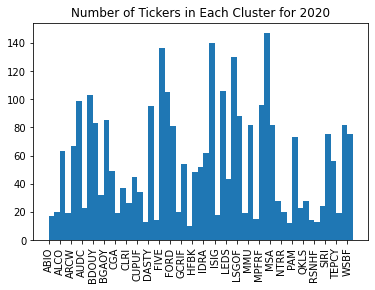

In [10]:
# Histogram of the number of tickers in each cluster
# For each histogram bin, the x ticker is the cluster center
# The y ticker is the number of tickers in the cluster
plt.hist(labels, bins=np.arange(len(cluster_centers_indices) + 1))
# Only show every other xtick
plt.xticks(np.arange(len(cluster_centers_indices))[::2], cluster_tickers[::2], rotation=90)
plt.title(f"Number of Tickers in Each Cluster for {year}")
plt.show()

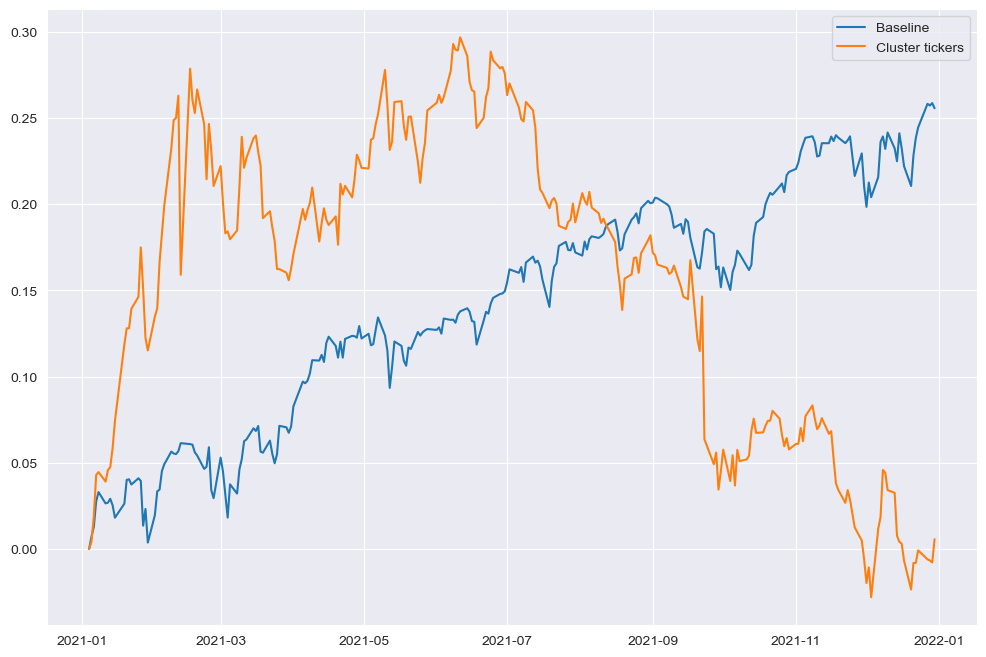

In [164]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 8))

baseline = backtest(year=year+1, baseline=True)
plt.plot(baseline, label='Baseline')

cluster_tickers_data = backtest(tickers=cluster_tickers, year=year + 1)
plt.plot(cluster_tickers_data, label='Cluster tickers')

plt.legend()